In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as ts
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import time
import os
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# specify stock

stock_col = 'AAPL'
# date_col = 'Date'

# define dataset inputs

# csvPath = '/Users/haidiazaman/Desktop/dsa5206-project/data/jena_climate_2009_2016.csv'
lookback_window = 8
batch_size = 128
train_size,val_size,test_size = 0.7,0.2,0.1

# define model inputs


input_size = 1 # equal to num features
hidden_size = 1
num_stacked_layers = 1
lr = 0.001
epochs = 100

scheduler_factor=0.5
scheduler_patience=3

early_stopping_limit = 10

# get data from yfinance

In [35]:
# get all the tickers on nasdaq
# https://github.com/shilewenuw/get_all_tickers/issues/12
import requests
import pandas as pd

headers = {
    'authority': 'api.nasdaq.com',
    'accept': 'application/json, text/plain, */*',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
    'origin': 'https://www.nasdaq.com',
    'sec-fetch-site': 'same-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://www.nasdaq.com/',
    'accept-language': 'en-US,en;q=0.9',
}

params = (
    ('tableonly', 'true'),
    ('limit', '25'),
    ('offset', '0'),
    ('download', 'true'),
)

r = requests.get('https://api.nasdaq.com/api/screener/stocks', headers=headers, params=params)
data = r.json()['data']
df = pd.DataFrame(data['rows'], columns=data['headers']) 
df['marketCap'] = pd.to_numeric(df['marketCap'], errors='coerce')
symbols = df.sort_values('marketCap', ascending=False)['symbol'] # sort symbols by market cap

In [36]:
df.sort_values('marketCap',ascending=False).head(100)

,symbol,name,lastsale,netchange,pctchange,marketCap,country,ipoyear,volume,sector,industry,url
17,AAPL,Apple Inc. Common Stock,$218.54,-6.47,-2.875%,3.351110e+12,United States,1980,61777576,Technology,Computer Manufacturing,/market-activity/stocks/aapl
4152,MSFT,Microsoft Corporation Common Stock,$428.90,-15.95,-3.585%,3.187716e+12,United States,1986,26805800,Technology,Computer Software: Prepackaged Software,/market-activity/stocks/msft
4502,NVDA,NVIDIA Corporation Common Stock,$114.25,-8.34,-6.803%,2.810361e+12,United States,1999,327776884,Technology,Semiconductors,/market-activity/stocks/nvda
2777,GOOG,Alphabet Inc. Class C Capital Stock,$174.37,-9.23,-5.027%,2.154864e+12,United States,2004,31250683,Technology,Computer Software: Programming Data Processing,/market-activity/stocks/goog
2778,GOOGL,Alphabet Inc. Class A Common Stock,$172.63,-9.16,-5.039%,2.133362e+12,United States,2004,49585203,Technology,Computer Software: Programming Data Processing,/market-activity/stocks/googl
...,...,...,...,...,...,...,...,...,...,...,...,...
898,BKNG,Booking Holdings Inc. Common Stock,$3805.78,-113.42,-2.894%,1.291207e+11,United States,,322139,Consumer Discretionary,Transportation Services,/market-activity/stocks/bkng
6615,VRTX,Vertex Pharmaceuticals Incorporated Common Stock,$490.80,0.48,0.098%,1.266526e+11,United States,1991,967464,Health Care,Biotechnology: Pharmaceutical Preparations,/market-activity/stocks/vrtx
4904,PGR,Progressive Corporation (The) Common Stock,$215.44,-0.46,-0.213%,1.261829e+11,United States,,2312822,Finance,Property-Casualty Insurers,/market-activity/stocks/pgr
6179,TJX,TJX Companies Inc. (The) Common Stock,$111.25,-2.17,-1.913%,1.257291e+11,United States,,4755676,Consumer Discretionary,Clothing/Shoe/Accessory Stores,/market-activity/stocks/tjx


In [37]:
tickers = yf.Tickers(list(symbols)[:100]) 
# tickers.tickers['NVDA'].history(period="1y")

In [38]:
multiple_prices = yf.download(list(symbols)[:100],period='1y',interval='1h')['Close']

# this gets the prices of the top 100 stocks based on marketCap

[********              16%%                      ]  16 of 100 completedFailed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)
[**********************49%%                      ]  49 of 100 completedFailed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  100 of 100 completed

2 Failed downloads:
['BRK/B', 'BRK/A']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


In [39]:
# multiple_prices.dropna(axis=1, inplace=True)

In [40]:
multiple_prices

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMAT,AMD,AMGN,AMZN,ARM,...,UBER,UL,UNH,UNP,V,VRTX,VZ,WFC,WMT,XOM
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-25 09:30:00-04:00,193.395004,142.574997,112.839996,313.390015,520.465027,139.960007,112.309998,235.789993,129.179993,NaN,...,47.259998,54.064999,508.744995,216.884995,239.370193,355.500000,34.095001,45.959999,53.003330,105.190002
2023-07-25 10:30:00-04:00,193.820007,142.080002,113.250000,315.445007,522.250000,140.970001,112.074699,235.720001,128.789993,NaN,...,47.535000,53.924999,509.845001,217.139999,240.250000,356.709991,34.221600,45.939999,52.933334,105.220001
2023-07-25 11:30:00-04:00,193.764694,142.059998,113.184998,315.609985,523.309998,140.429993,112.570000,235.779999,128.990005,NaN,...,47.299999,53.794998,511.290009,217.000000,239.875000,355.880005,34.334999,45.965000,53.039997,105.459999
2023-07-25 12:30:00-04:00,194.199997,141.779999,112.930000,317.531097,524.989990,140.600006,112.919998,235.814499,129.160004,NaN,...,47.435001,53.730000,510.070007,215.945007,239.835007,356.505005,34.189999,45.994999,52.896667,105.705002
2023-07-25 13:30:00-04:00,194.121201,141.875000,112.940002,318.130005,523.705017,140.524994,113.470100,236.169998,129.005005,NaN,...,47.294998,53.745201,511.209991,216.529999,239.740005,357.570007,34.169998,45.955002,52.828335,105.959999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24 11:30:00-04:00,217.904999,175.740005,106.224998,330.630005,532.469971,208.695007,147.050003,336.519989,181.669998,161.000000,...,66.180000,56.942001,557.354980,240.149994,253.895004,490.575012,39.685001,59.759998,70.599998,114.910004
2024-07-24 12:30:00-04:00,218.025803,175.964996,106.440002,329.325012,534.174988,209.410004,147.339996,336.334991,182.070007,161.975006,...,66.044998,56.869999,557.599976,239.472504,256.149994,490.630005,39.715000,59.650002,70.595001,114.786003
2024-07-24 13:30:00-04:00,218.160004,176.054993,106.860001,329.880005,532.844971,208.210007,146.485001,336.345001,181.789993,159.731903,...,66.109100,56.825001,561.000000,238.875000,256.579987,490.804993,39.680000,59.759998,70.650002,114.970001


# dataset
- preprocess dataset 
    - format into df with lookback window
    - normalize features
    - train val test split

In [12]:
multiple_prices

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMAT,AMD,AMGN,AMZN,ARM,...,UBER,UL,UNH,UNP,V,VRTX,VZ,WFC,WMT,XOM
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-25 09:30:00-04:00,193.395004,142.574997,112.839996,313.390015,520.465027,139.960007,112.309998,235.789993,129.179993,NaN,...,47.259998,54.064999,508.744995,216.884995,239.370193,355.500000,34.095001,45.959999,53.003330,105.190002
2023-07-25 10:30:00-04:00,193.820007,142.080002,113.250000,315.445007,522.250000,140.970001,112.074699,235.720001,128.789993,NaN,...,47.535000,53.924999,509.845001,217.139999,240.250000,356.709991,34.221600,45.939999,52.933334,105.220001
2023-07-25 11:30:00-04:00,193.764694,142.059998,113.184998,315.609985,523.309998,140.429993,112.570000,235.779999,128.990005,NaN,...,47.299999,53.794998,511.290009,217.000000,239.875000,355.880005,34.334999,45.965000,53.039997,105.459999
2023-07-25 12:30:00-04:00,194.199997,141.779999,112.930000,317.531097,524.989990,140.600006,112.919998,235.814499,129.160004,NaN,...,47.435001,53.730000,510.070007,215.945007,239.835007,356.505005,34.189999,45.994999,52.896667,105.705002
2023-07-25 13:30:00-04:00,194.121201,141.875000,112.940002,318.130005,523.705017,140.524994,113.470100,236.169998,129.005005,NaN,...,47.294998,53.745201,511.209991,216.529999,239.740005,357.570007,34.169998,45.955002,52.828335,105.959999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24 11:30:00-04:00,217.904999,175.740005,106.224998,330.630005,532.469971,208.695007,147.050003,336.519989,181.669998,161.000000,...,66.180000,56.942001,557.354980,240.149994,253.895004,490.575012,39.685001,59.759998,70.599998,114.910004
2024-07-24 12:30:00-04:00,218.025803,175.964996,106.440002,329.325012,534.174988,209.410004,147.339996,336.334991,182.070007,161.975006,...,66.044998,56.869999,557.599976,239.472504,256.149994,490.630005,39.715000,59.650002,70.595001,114.786003
2024-07-24 13:30:00-04:00,218.160004,176.054993,106.860001,329.880005,532.844971,208.210007,146.485001,336.345001,181.789993,159.731903,...,66.109100,56.825001,561.000000,238.875000,256.579987,490.804993,39.680000,59.759998,70.650002,114.970001


In [87]:
# prepare df for univariate time series forecasting

df = multiple_prices[[stock_col]].reset_index()
df

Ticker,Datetime,AAPL
0,2023-07-25 09:30:00-04:00,193.395004
1,2023-07-25 10:30:00-04:00,193.820007
2,2023-07-25 11:30:00-04:00,193.764694
3,2023-07-25 12:30:00-04:00,194.199997
4,2023-07-25 13:30:00-04:00,194.121201
...,...,...
1752,2024-07-24 11:30:00-04:00,217.904999
1753,2024-07-24 12:30:00-04:00,218.025803
1754,2024-07-24 13:30:00-04:00,218.160004
1755,2024-07-24 14:30:00-04:00,217.889999


In [88]:
date_col = 'Datetime'

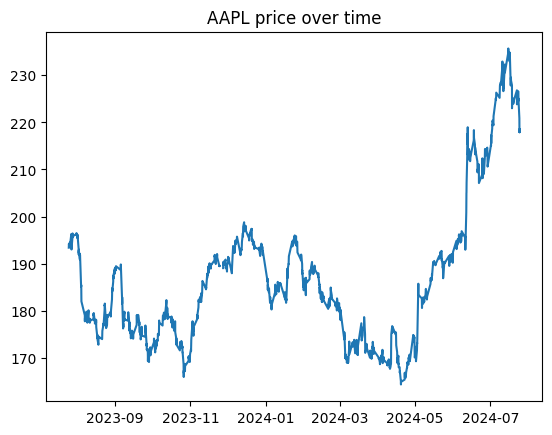

In [89]:
plt.plot(df[date_col],df[stock_col])
plt.title(f'{stock_col} price over time')
plt.show()

In [92]:
# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [93]:
# format df into df with lookback window
def prepare_shifted_df(df, lookback_window, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, lookback_window+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df


def process_shifted_df(shifted_df,lookback_window):
    # format X and y from df and scale it
    shifted_df_as_np = shifted_df.to_numpy()
    # print(shifted_df_as_np.shape)

    # normalise the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, -1]
    # print(X.shape, y.shape)
    X = dc(np.flip(X, axis=1))
    
    X = X.reshape(-1,lookback_window,1)
    y = y.reshape(-1,1)
    return X,y

In [139]:
df

Ticker,Datetime,AAPL
0,2023-07-25 09:30:00-04:00,193.395004
1,2023-07-25 10:30:00-04:00,193.820007
2,2023-07-25 11:30:00-04:00,193.764694
3,2023-07-25 12:30:00-04:00,194.199997
4,2023-07-25 13:30:00-04:00,194.121201
...,...,...
1752,2024-07-24 11:30:00-04:00,217.904999
1753,2024-07-24 12:30:00-04:00,218.025803
1754,2024-07-24 13:30:00-04:00,218.160004
1755,2024-07-24 14:30:00-04:00,217.889999


In [140]:
shifted_df = prepare_shifted_df(df, lookback_window=lookback_window, date_col_name=date_col, value_col_name=stock_col)
shifted_df

Ticker,AAPL,AAPL(t-1),AAPL(t-2),AAPL(t-3),AAPL(t-4),AAPL(t-5),AAPL(t-6),AAPL(t-7),AAPL(t-8)
Datetime,,,,,,,,,
2023-07-26 10:30:00-04:00,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,193.820007,193.395004
2023-07-26 11:30:00-04:00,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,193.820007
2023-07-26 12:30:00-04:00,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694
2023-07-26 13:30:00-04:00,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997
2023-07-26 14:30:00-04:00,194.214996,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201
...,...,...,...,...,...,...,...,...,...
2024-07-24 11:30:00-04:00,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893,226.608902
2024-07-24 12:30:00-04:00,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893
2024-07-24 13:30:00-04:00,218.160004,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001


In [141]:
shifted_df['AAPL_diff']=shifted_df['AAPL'].diff()
shifted_df

Ticker,AAPL,AAPL(t-1),AAPL(t-2),AAPL(t-3),AAPL(t-4),AAPL(t-5),AAPL(t-6),AAPL(t-7),AAPL(t-8),AAPL_diff
Datetime,,,,,,,,,,
2023-07-26 10:30:00-04:00,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,193.820007,193.395004,NaN
2023-07-26 11:30:00-04:00,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,193.820007,0.269989
2023-07-26 12:30:00-04:00,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,-0.149994
2023-07-26 13:30:00-04:00,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,-0.089996
2023-07-26 14:30:00-04:00,194.214996,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,-0.055008
...,...,...,...,...,...,...,...,...,...,...
2024-07-24 11:30:00-04:00,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893,226.608902,-0.770004
2024-07-24 12:30:00-04:00,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893,0.120804
2024-07-24 13:30:00-04:00,218.160004,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,0.134201


In [142]:
shifted_df=shifted_df.iloc[1:]
shifted_df

Ticker,AAPL,AAPL(t-1),AAPL(t-2),AAPL(t-3),AAPL(t-4),AAPL(t-5),AAPL(t-6),AAPL(t-7),AAPL(t-8),AAPL_diff
Datetime,,,,,,,,,,
2023-07-26 11:30:00-04:00,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,193.820007,0.269989
2023-07-26 12:30:00-04:00,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,193.764694,-0.149994
2023-07-26 13:30:00-04:00,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,194.199997,-0.089996
2023-07-26 14:30:00-04:00,194.214996,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,194.121201,-0.055008
2023-07-26 15:30:00-04:00,194.520004,194.214996,194.270004,194.360001,194.509995,194.240005,193.979996,193.630005,194.274994,0.305008
...,...,...,...,...,...,...,...,...,...,...
2024-07-24 11:30:00-04:00,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893,226.608902,-0.770004
2024-07-24 12:30:00-04:00,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,225.639893,0.120804
2024-07-24 13:30:00-04:00,218.160004,218.025803,217.904999,218.675003,220.889999,225.009995,225.074707,224.539993,224.720001,0.134201


<AxesSubplot:xlabel='Datetime'>

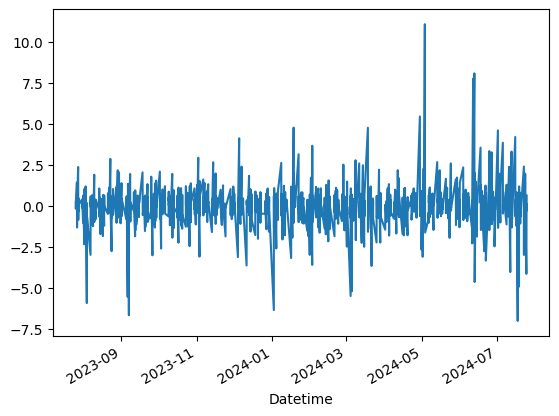

In [143]:
shifted_df['AAPL_diff'].plot()

In [144]:
def process_shifted_df(shifted_df,lookback_window):
    # format X and y from df and scale it
    shifted_df_as_np = shifted_df.to_numpy()
    # print(shifted_df_as_np.shape)

    # normalise the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
    X = shifted_df_as_np[:, 1:-1]
    y = shifted_df_as_np[:, -1]
    # print(X.shape, y.shape)
    X = dc(np.flip(X, axis=1))
    
    X = X.reshape(-1,lookback_window,1)
    y = y.reshape(-1,1)
    return X,y

In [145]:
X,y = process_shifted_df(shifted_df,lookback_window=lookback_window)
X.shape,y.shape

((1739, 8, 1), (1739, 1))

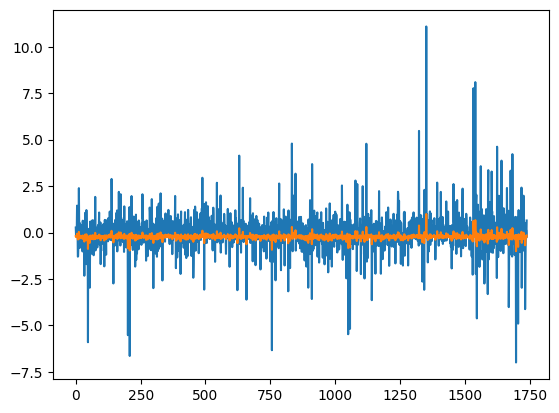

In [146]:
plt.plot(shifted_df['AAPL_diff'].tolist())
plt.plot(y)

In [147]:
shifted_df.AAPL_diff.min()

-6.989990234375

In [132]:
y.max()

tensor(0.2843)

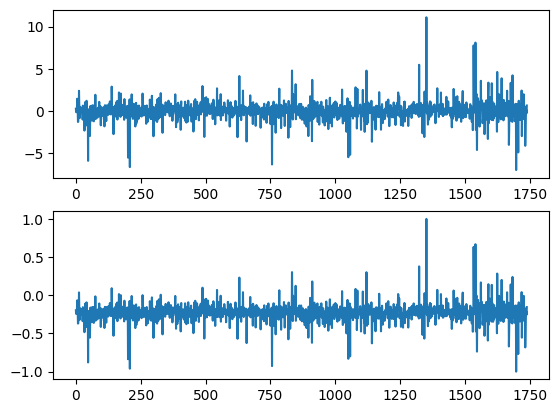

In [111]:
plt.subplot(2,1,1)
plt.plot(shifted_df['AAPL_diff'].tolist())

plt.subplot(2,1,2)
plt.plot(y)

In [148]:
y[0]

array([-0.19690435])

In [149]:
y*=10
y[0]

array([-1.96904354])

In [150]:
# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)

y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(y_train.shape, y_val.shape, y_test.shape)

# convert to torch tensor
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
print(X_train.shape, X_val.shape, X_test.shape)

y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(y_train.shape, y_val.shape, y_test.shape)

(1217, 8, 1) (347, 8, 1) (175, 8, 1)
(1217, 1) (347, 1) (175, 1)
torch.Size([1217, 8, 1]) torch.Size([347, 8, 1]) torch.Size([175, 8, 1])
torch.Size([1217, 1]) torch.Size([347, 1]) torch.Size([175, 1])


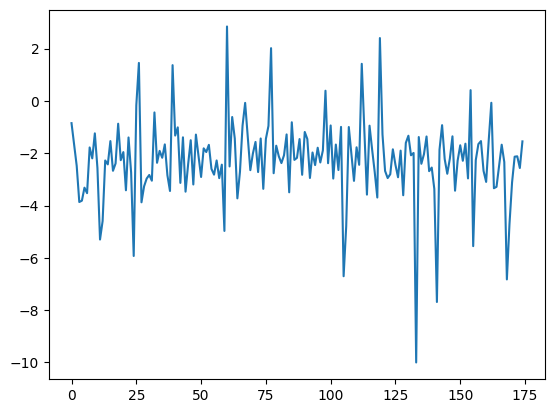

In [151]:
plt.plot(y_test)

In [152]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [153]:
# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 8, 1]) torch.Size([128, 1])


In [154]:
x_batch[0],y_batch[0]

(tensor([[-0.1739],
         [-0.1755],
         [-0.1632],
         [-0.1655],
         [-0.1611],
         [-0.1792],
         [-0.1694],
         [-0.1621]]),
 tensor([-1.9690]))

# Define Models

In [117]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0) # input must be torch tensor
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # short term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # long term memory

        out, _ = self.lstm(x, (h0, c0)) # output is output, (h_n, c_n), but we dont need to track the next state h1,c1 as the model does it for us
        # out shape is (batch_size, num_timesteps inclusive of predicted day, num_features_in_hidden_state)
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # rnn only has h0 short term memory, no c0 long term memory

        out, _ = self.rnn(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # gru only has h0 memory, no c0 long term memory

        out, _ = self.gru(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out

# RNN - train

In [155]:
# define model inputs


input_size = 1 # equal to num features
hidden_size = 8
num_stacked_layers = 2
lr = 0.001
epochs = 100

scheduler_factor=0.5
scheduler_patience=3

early_stopping_limit = 10

Early stopping!


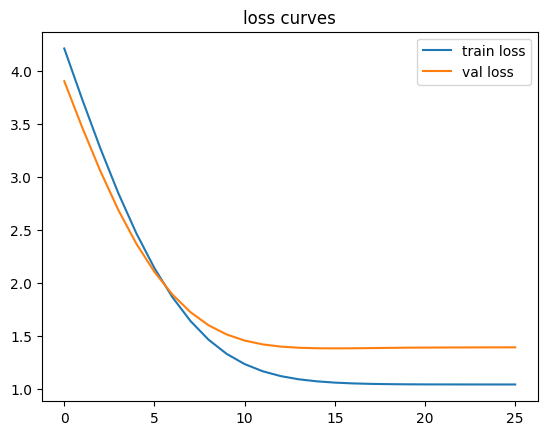

2.401195 1.023573


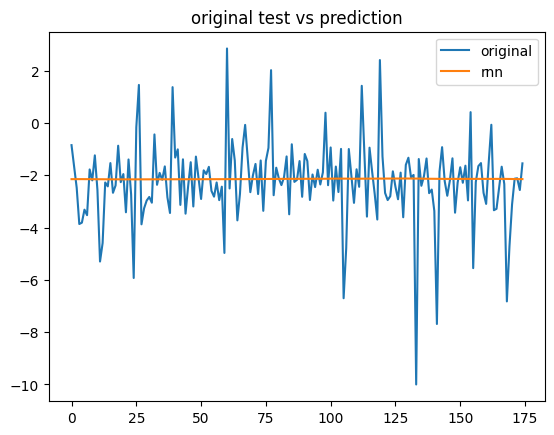

In [157]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    # print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'rnn.pt')
        # print(f'model epoch {epoch} saved as rnn.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    # print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")



# EVALUATE

# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.title("loss curves")
plt.legend()
plt.show()

# EVAL ON TEST DATASET

# load best pretraining model
best_model_path = 'rnn.pt'
rnn_model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()

# latent_vector = pretraining_model.get_latent_vector(X_test.to(device))
predictions = rnn_model(X_test.to(device))
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

# plt.plot(y[:100],label='original')
# plt.plot(pred[:100],label='rnn')
plt.plot(y,label='original')
plt.plot(pred,label='rnn')

plt.title('original test vs prediction')
plt.legend()
plt.show()

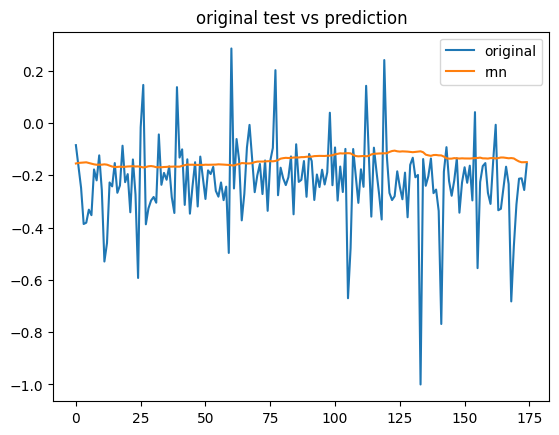

In [129]:

# plt.plot(y[:100],label='original')
# plt.plot(pred[:100],label='rnn')
plt.plot(y,label='original')
plt.plot(pred*1,label='rnn')

plt.title('original test vs prediction')
plt.legend()
plt.show()

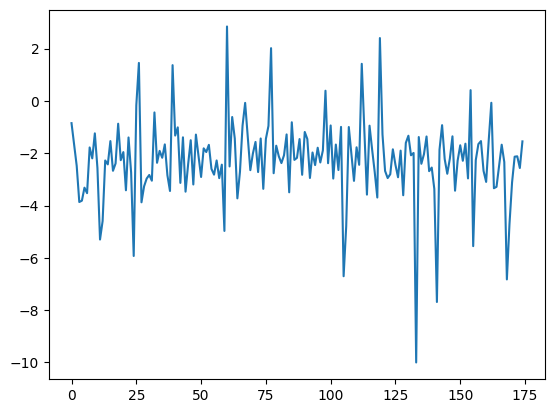

In [160]:
plt.plot(y)

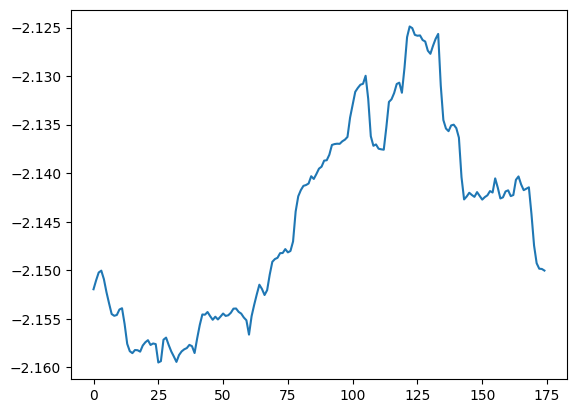

In [161]:
plt.plot(pred)